# Rathmines - NO2 2016 Predictions (Hour and Daily)

# Import Packages

In [74]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, max_error

from time import process_time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score

# Import Cleaned Dataset

In [75]:
df = pd.read_csv('Rathmines_FileforML.csv', thousands=',', low_memory=False)

# Drop all unnecessary columns

In [76]:
df = df.dropna(axis=0)

In [77]:
#Change date data type
df['Date'] = df['Date'].astype('datetime64')

In [78]:
def DropHead(Dataframe, Feature):

    Dataframe.drop(Feature, axis=1, inplace=True)
    
DropHead(df, 'indtemp')
DropHead(df, 'indwetb')
DropHead(df, 'indwdsp')
DropHead(df, 'indwddir')
DropHead(df, 'wetb')
DropHead(df, 'dewpt')
DropHead(df, 'vappr')
DropHead(df, 'rhum')
DropHead(df, 'ww')
DropHead(df, 'w')
DropHead(df, 'sun')
DropHead(df, 'vis')
DropHead(df, 'clht')
DropHead(df, 'clamt')
DropHead(df, 'NOX')
DropHead(df, 'NO')
DropHead(df, 'PM25')

In [79]:
print("Number of rows in dataset is: {}".format(len(df)))

Number of rows in dataset is: 12595


In [80]:
#Sanity check
df.head()

,Date,Hour,indrain,rain,temp,msl,wdsp,wddir,NO2,Ozone,SO2,PM10
6142,2017-11-22 12:00:00,12,0,0.6,8.8,983.5,10,360,28.65,46.4,3.5,3.3
6143,2017-11-22 13:00:00,13,0,0.4,9.0,983.2,4,360,34.38,46.2,3.5,5.5
6144,2017-11-22 14:00:00,14,0,0.2,9.1,983.3,4,200,40.30,35.0,3.2,7.8
6145,2017-11-22 15:00:00,15,0,0.2,9.1,982.5,4,290,54.05,17.8,3.5,10.8
6146,2017-11-22 16:00:00,16,0,0.5,7.0,982.1,6,340,58.64,12.4,3.7,11.2


In [81]:
#Only take positive pollutant values
Posdf = df[(df['SO2'] >= 0) & (df['Ozone'] >= 0) & (df['NO2'] >= 0) & (df['PM10'] >= 0)]

In [82]:
Posdf.head()

,Date,Hour,indrain,rain,temp,msl,wdsp,wddir,NO2,Ozone,SO2,PM10
6142,2017-11-22 12:00:00,12,0,0.6,8.8,983.5,10,360,28.65,46.4,3.5,3.3
6143,2017-11-22 13:00:00,13,0,0.4,9.0,983.2,4,360,34.38,46.2,3.5,5.5
6144,2017-11-22 14:00:00,14,0,0.2,9.1,983.3,4,200,40.30,35.0,3.2,7.8
6145,2017-11-22 15:00:00,15,0,0.2,9.1,982.5,4,290,54.05,17.8,3.5,10.8
6146,2017-11-22 16:00:00,16,0,0.5,7.0,982.1,6,340,58.64,12.4,3.7,11.2


In [83]:
Posdf.describe()

,Hour,indrain,rain,temp,msl,wdsp,wddir,NO2,Ozone,SO2,PM10
count,12369.000000,12369.0,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000,12369.000000
mean,11.890614,0.0,0.106104,10.114439,1013.315919,9.707656,201.544992,20.264229,48.899927,1.807056,12.473684
std,6.825923,0.0,0.445379,4.982197,12.762304,4.741276,81.769412,16.121979,21.313736,1.601337,11.671087
min,0.000000,0.0,0.000000,0.200000,972.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.0,0.000000,6.400000,1005.300000,6.000000,140.000000,8.600000,35.200000,0.800000,5.900000
50%,12.000000,0.0,0.000000,9.500000,1015.200000,9.000000,220.000000,16.400000,50.000000,1.330000,9.300000
75%,18.000000,0.0,0.000000,13.600000,1022.100000,12.000000,260.000000,27.100000,62.800000,2.130000,15.100000
max,23.000000,0.0,10.500000,26.300000,1044.500000,34.000000,360.000000,183.000000,153.600000,29.260000,173.500000


# Adjust Values prior to input into algorithms

In [84]:
Posdf['Ozone'] = Posdf['Ozone']+1.00
Posdf['PM10'] = Posdf['PM10']+1.00
Posdf['SO2'] = Posdf['SO2']+1.00
Posdf['NO2'] = Posdf['NO2']+1.00
Posdf['wdsp'] = Posdf['wdsp']+1.00
Posdf['temp'] = Posdf['temp']+1.00
Posdf['rain'] = Posdf['rain']+1.00
Posdf['Hour'] = Posdf['Hour']+1.00
Posdf['wddir'] = Posdf['wddir']/360 + 1.00
Posdf['msl'] = Posdf['msl']/1000


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

# Set up data so that NO2 is the target pollutant

In [85]:
Posdf1719 = Posdf[['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'PM10', 'SO2', 'NO2']].copy()

# Import the actual 2016 Data for NO2 and the 2016 pollutant data since this will be the testing data

In [86]:
HrNO2_16 = pd.read_csv('Dublin_Rathmines_NO2_hr.csv', thousands=',', low_memory=False)

In [87]:
DY16 = pd.read_csv('Rathmines Met and Pollutant Data 2016.csv', thousands=',', low_memory=False)

In [88]:
#Change date data type
HrNO2_16['Date'] = HrNO2_16['Date'].astype('datetime64')
DY16['Date'] = DY16['Date'].astype('datetime64')

In [89]:
#Sanity check
DY16.head()

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,wddir,ww,w,sun,vis,clht,clamt,Ozone,NO2,SO2
0,2016-01-01 00:00:00,0,3,0.0,0,1.9,0,0.8,-1.2,5.6,...,200,2,11,0.0,40000,240,4,47.6,11.460000,0.3
1,2016-01-01 01:00:00,1,3,0.0,0,1.6,0,0.5,-1.5,5.5,...,200,2,11,0.0,40000,240,4,50.5,10.791500,0.1
2,2016-01-01 02:00:00,2,3,0.0,0,0.7,1,-0.2,-1.8,5.3,...,190,2,11,0.0,40000,240,4,37.8,20.882666,-0.6
3,2016-01-01 03:00:00,3,3,0.0,0,0.8,1,-0.2,-2.1,5.2,...,170,2,11,0.0,40000,240,4,9.6,40.301000,-0.3
4,2016-01-01 04:00:00,4,3,0.0,0,2.9,0,1.3,-1.6,5.4,...,170,2,11,0.0,40000,240,4,16.2,40.730750,-0.5


In [90]:
#Delete the columns that are unnecessary
Y16 = DY16[['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'NO2', 'SO2']].copy()

In [91]:
#This function selects all the rows of data where the pollutant columns have a null value will be removed later
def DropDates(Set):
    Date = []
    Date = Set.loc[(Set['SO2'].isnull() | Set['NO2'].isnull() | Set['Ozone'].isnull(), 'Date')].values
   
    return Date

#This is a dataset of all the rows with null values
Date16 = DropDates(DY16)



In [92]:
#These are the 2016 dates with null values in a row
df16 = pd.DataFrame(list(zip(Date16)), columns =['Date NaN'])

df16['Dates'] = pd.to_datetime(df16['Date NaN']).dt.date

In [93]:
#Check that the datetimes were split
df16.head()

,Date NaN,Dates
0,2016-01-20 12:00:00,2016-01-20
1,2016-01-20 13:00:00,2016-01-20
2,2016-01-26 14:00:00,2016-01-26
3,2016-01-26 15:00:00,2016-01-26
4,2016-02-02 09:00:00,2016-02-02


In [94]:
#Split the datetimes on the original 2016 dataset
DY16['Dates'] = pd.to_datetime(DY16['Date']).dt.date
DY16['Time'] = pd.to_datetime(DY16['Date']).dt.time
display(DY16)

,Date,Hour,indrain,rain,indtemp,temp,indwetb,wetb,dewpt,vappr,...,w,sun,vis,clht,clamt,Ozone,NO2,SO2,Dates,Time
0,2016-01-01 00:00:00,0,3,0.0,0,1.9,0,0.8,-1.2,5.6,...,11,0.0,40000,240,4,47.6,11.460000,0.3,2016-01-01,00:00:00
1,2016-01-01 01:00:00,1,3,0.0,0,1.6,0,0.5,-1.5,5.5,...,11,0.0,40000,240,4,50.5,10.791500,0.1,2016-01-01,01:00:00
2,2016-01-01 02:00:00,2,3,0.0,0,0.7,1,-0.2,-1.8,5.3,...,11,0.0,40000,240,4,37.8,20.882666,-0.6,2016-01-01,02:00:00
3,2016-01-01 03:00:00,3,3,0.0,0,0.8,1,-0.2,-2.1,5.2,...,11,0.0,40000,240,4,9.6,40.301000,-0.3,2016-01-01,03:00:00
4,2016-01-01 04:00:00,4,3,0.0,0,2.9,0,1.3,-1.6,5.4,...,11,0.0,40000,240,4,16.2,40.730750,-0.5,2016-01-01,04:00:00
5,2016-01-01 05:00:00,5,3,0.0,0,3.0,0,1.5,-1.1,5.6,...,11,0.0,40000,240,4,26.1,32.947500,-0.2,2016-01-01,05:00:00
6,2016-01-01 06:00:00,6,0,0.0,0,3.6,0,2.1,-0.6,5.9,...,11,0.0,40000,200,4,13.6,37.674750,-0.5,2016-01-01,06:00:00
7,2016-01-01 07:00:00,7,0,0.0,0,3.9,0,2.5,0.3,6.2,...,11,0.0,40000,150,6,22.6,28.268000,-0.6,2016-01-01,07:00:00
8,2016-01-01 08:00:00,8,0,0.0,0,3.9,0,2.7,0.7,6.5,...,11,0.0,40000,130,6,40.2,16.139500,-0.5,2016-01-01,08:00:00
9,2016-01-01 09:00:00,9,0,0.0,0,5.7,0,4.5,2.9,7.5,...,11,0.0,30000,120,7,21.9,35.955750,0.1,2016-01-01,09:00:00


In [95]:
#This function removes all the rows of data containing at least one "NaN" 
#from the original 2016 dataset.
def CleanNans(Frame1, Frame2):
    a = []
    a = Frame2['Dates'].values
    newdf = Frame1[~Frame1['Dates'].isin(a)]
   
    return newdf

#2016 hourly data with no "NaN" values 
ndf16 = CleanNans(DY16, df16)


print("The length of the dataset is: {}".format(len(ndf16)))

The length of the dataset is: 6720


Note how this value is a multiple of 24 i.e. 24 hours in the day. It was decided that it was best to only do daily averages for data where the entire 24hrs were available. Otherwise the daily averages may be not as effective. This is 280 days

In [96]:
#Sanity check that I have 24 values for the one date
print(ndf16)

                    Date  Hour  indrain  rain  indtemp  temp  indwetb  wetb  \
0    2016-01-01 00:00:00     0        3   0.0        0   1.9        0   0.8   
1    2016-01-01 01:00:00     1        3   0.0        0   1.6        0   0.5   
2    2016-01-01 02:00:00     2        3   0.0        0   0.7        1  -0.2   
3    2016-01-01 03:00:00     3        3   0.0        0   0.8        1  -0.2   
4    2016-01-01 04:00:00     4        3   0.0        0   2.9        0   1.3   
5    2016-01-01 05:00:00     5        3   0.0        0   3.0        0   1.5   
6    2016-01-01 06:00:00     6        0   0.0        0   3.6        0   2.1   
7    2016-01-01 07:00:00     7        0   0.0        0   3.9        0   2.5   
8    2016-01-01 08:00:00     8        0   0.0        0   3.9        0   2.7   
9    2016-01-01 09:00:00     9        0   0.0        0   5.7        0   4.5   
10   2016-01-01 10:00:00    10        0   0.1        0   7.6        0   6.0   
11   2016-01-01 11:00:00    11        0   0.0       

In [97]:
#Create a dataframe so that the cleaned datas are available for use later
DYear16 = ndf16[['Date']].copy()
DYear16['Dates'] = pd.to_datetime(DYear16['Date']).dt.date
DYear16['Time'] = pd.to_datetime(DYear16['Date']).dt.time
display(DYear16)

,Date,Dates,Time
0,2016-01-01 00:00:00,2016-01-01,00:00:00
1,2016-01-01 01:00:00,2016-01-01,01:00:00
2,2016-01-01 02:00:00,2016-01-01,02:00:00
3,2016-01-01 03:00:00,2016-01-01,03:00:00
4,2016-01-01 04:00:00,2016-01-01,04:00:00
5,2016-01-01 05:00:00,2016-01-01,05:00:00
6,2016-01-01 06:00:00,2016-01-01,06:00:00
7,2016-01-01 07:00:00,2016-01-01,07:00:00
8,2016-01-01 08:00:00,2016-01-01,08:00:00
9,2016-01-01 09:00:00,2016-01-01,09:00:00


# Create the Testing Data
In this dataframe the input parameters from only the cleaned 280 days are combined. <br>
Note how NO2 is not included since it is the target pollutant!

In [98]:
Year16 = ndf16[['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']].copy()
display(Year16)

,Hour,rain,temp,msl,wdsp,wddir,Ozone,SO2
0,0,0.0,1.9,1016.2,8,200,47.6,0.3
1,1,0.0,1.6,1016.3,7,200,50.5,0.1
2,2,0.0,0.7,1016.5,6,190,37.8,-0.6
3,3,0.0,0.8,1016.4,6,170,9.6,-0.3
4,4,0.0,2.9,1016.2,5,170,16.2,-0.5
5,5,0.0,3.0,1015.7,7,160,26.1,-0.2
6,6,0.0,3.6,1014.7,8,150,13.6,-0.5
7,7,0.0,3.9,1014.2,7,150,22.6,-0.6
8,8,0.0,3.9,1013.4,6,120,40.2,-0.5
9,9,0.0,5.7,1012.1,7,130,21.9,0.1


# In the cell below Actual NO2 daily averages are calculated from the Actual Hourly data 
This is done since there was no daily average data available for NO2 at this site.
Only the same days as the testing data are used

In [99]:
ind_date = []
ind_date = HrNO2_16['Date'].unique()
NO2_16hr = ndf16[['Date', 'NO2']].copy()
NO2_16hr['Dates'] = pd.to_datetime(NO2_16hr['Date']).dt.date
NO2_16hr['Time'] = pd.to_datetime(NO2_16hr['Date']).dt.time

ind_date16 = []
ind_date16 = NO2_16hr['Dates'].unique()
avg = NO2_16hr.groupby(NO2_16hr.Dates).mean()

a = []
a = avg[['NO2']].values

NO2_Day = pd.DataFrame(list(zip(ind_date16, a)), columns =['Date', 'NO2'])

print("Length of NO2 actual daily averages: {}".format(len(NO2_Day)))

Length of NO2 actual daily averages: 280


This is the same number of days as the testing data

# Drop PM10 from training data since it is not included in the testing data
This was due to the lack of hourly PM10 data at this site for 2016

In [100]:
Posdf1719.drop('PM10', axis=1, inplace=True)

In [101]:
Posdf1719.head()

,Hour,rain,temp,msl,wdsp,wddir,Ozone,SO2,NO2
6142,13.0,1.6,9.8,0.9835,11.0,2.000000,47.4,4.5,29.65
6143,14.0,1.4,10.0,0.9832,5.0,2.000000,47.2,4.5,35.38
6144,15.0,1.2,10.1,0.9833,5.0,1.555556,36.0,4.2,41.30
6145,16.0,1.2,10.1,0.9825,5.0,1.805556,18.8,4.5,55.05
6146,17.0,1.5,8.0,0.9821,7.0,1.944444,13.4,4.7,59.64


In [102]:
Year16.describe()

,Hour,rain,temp,msl,wdsp,wddir,Ozone,SO2
count,6720.000000,6720.000000,6720.000000,6720.000000,6720.000000,6720.000000,6720.000000,6720.000000
mean,11.500000,0.076369,10.190774,1013.883423,10.624107,203.360119,35.135967,1.789152
std,6.922702,0.345784,5.312850,11.634130,5.382366,84.408704,20.920675,1.842707
min,0.000000,0.000000,-4.800000,968.200000,0.000000,0.000000,-14.000000,-3.700000
25%,5.750000,0.000000,6.100000,1007.300000,7.000000,140.000000,21.000000,0.500000
50%,11.500000,0.000000,10.500000,1015.600000,10.000000,230.000000,34.600000,1.300000
75%,17.250000,0.000000,14.300000,1021.800000,14.000000,260.000000,51.200000,2.400000
max,23.000000,8.400000,26.000000,1041.900000,35.000000,360.000000,90.200000,26.600000


# Adjust the testing data aswell

In [103]:
Year16['Ozone'] = Year16['Ozone']+15.00
Year16['Hour'] = Year16['Hour']+1.00
Year16['rain'] = Year16['rain']+1.00
Year16['temp'] = Year16['temp']+5.80
Year16['wdsp'] = Year16['wdsp']+1.00
Year16['SO2'] = Year16['SO2']+4.70
Year16['wddir'] = Year16['wddir']/360 + 1.00
Year16['msl'] = Year16['msl']/1000

In [104]:
display(Year16)

,Hour,rain,temp,msl,wdsp,wddir,Ozone,SO2
0,1.0,1.0,7.7,1.0162,9.0,1.555556,62.6,5.0
1,2.0,1.0,7.4,1.0163,8.0,1.555556,65.5,4.8
2,3.0,1.0,6.5,1.0165,7.0,1.527778,52.8,4.1
3,4.0,1.0,6.6,1.0164,7.0,1.472222,24.6,4.4
4,5.0,1.0,8.7,1.0162,6.0,1.472222,31.2,4.2
5,6.0,1.0,8.8,1.0157,8.0,1.444444,41.1,4.5
6,7.0,1.0,9.4,1.0147,9.0,1.416667,28.6,4.2
7,8.0,1.0,9.7,1.0142,8.0,1.416667,37.6,4.1
8,9.0,1.0,9.7,1.0134,7.0,1.333333,55.2,4.2
9,10.0,1.0,11.5,1.0121,8.0,1.361111,36.9,4.8


# Functions to conduct the algorithms

In [105]:
def evaluate_model(X_test, y_test, model):
    
    # compute predictions for the test set
    _predicted_values = model.predict(X_test)
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
    _meae = median_absolute_error(y_test, _predicted_values)
    _evs = explained_variance_score(y_test, _predicted_values)
    _me = max_error(y_test, _predicted_values)      
    return _mse, _mae, _r2, _meae, _evs, _me

In [106]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [107]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

# Random Forest

In [108]:
%%time

def RandomForest(Name, Input1, Input2, N, printCV, printgraph, N_Features, Max_Depth, ratio, PM):
    
    Data = Input1
    
    names_all = [c for c in Data if c not in ['NO2']]

    column_list = Data.columns.values.tolist()
    Removed     = column_list.pop(-1)
    
    # define column groups with the same data preparation
    names_outliers = column_list
    print(names_outliers)
    names_no_outliers = list(set(names_all) - set(names_outliers))
    
    y = Data['NO2']
    X = Data.drop('NO2', axis=1).values
    #y_test = Year2020['PM10']
    X_test = Input2
    
    preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)
   
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, shuffle=True)
    X_train, y_train = X, y
    
    pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                        ('regresson', RandomForestRegressor(n_estimators=100))])

    
    #print(len(Data))
    
    
    N_FEATURES_OPTIONS = [N_Features]
    MAX_DEPTH_OPTIONS = [Max_Depth]

    param_grid = [
        {
            'reduce_dim': [PCA(iterated_power=7)],
            'reduce_dim__n_components': N_FEATURES_OPTIONS,
            'regresson__max_depth': MAX_DEPTH_OPTIONS
        },
        {
            'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
            'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
            'regresson__max_depth': MAX_DEPTH_OPTIONS
        },
        {
            'reduce_dim': [FastICA( algorithm='deflation')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS,
            'regresson__max_depth': MAX_DEPTH_OPTIONS
        },
        {
            'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
    ]    

    search = GridSearchCV(pipe, param_grid, cv=10, iid = False, refit=True)
    search.fit(X_train, y_train)

    if printCV == 0:
        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)
    
        
 
    # store the best params and best model for later use
    RF_best_params = search.best_params_
    RF_best_model = search.best_estimator_
    
    if printgraph == 0:
        model = RandomForestRegressor()
        visualizer = PredictionError(model)

        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure
    
    #RF_mse, RF_mae, RF_r2, RF_meae, RF_evs, RF_me = evaluate_model(X_test, y_test, RF_best_model)
    
    Title = np.array([Name])
    Range = np.array([N])
    Features = np.array([N_Features])
    Depth = np.array([Max_Depth])
    Split = np.array([ratio])
    PM_70 = np.array([PM])
    #MSE  = np.array([RF_mse])
    #MAE  = np.array([RF_mae])
    #R2   = np.array([RF_r2])
    #MEAE = np.array([RF_meae])
    #ME   = np.array([RF_me])
    
    Predictions = model.predict(X_test)
    #df = pd.DataFrame(list(zip(Title, Range, Features, Depth, Split, PM_70, MSE, MAE, R2, MEAE, ME)), columns =['Algorithm', 'Year', 'N Features', 'Max Depth', 'Test-Train Split', 'PM10 > 70 Removed', 'MSE', 'MAE', 'R2', 'MEAE', 'ME'])
    
    return Predictions


Wall time: 0 ns


# Gradient Boosting

In [109]:
%%time
def GradientBoosting(Name, Input1, Input2, N, printCV, printgraph, N_Features, Max_Depth, ratio, PM):
    Data = Input1
    
    names_all = [c for c in Data if c not in ['NO2']]

    column_list = Data.columns.values.tolist()
    Removed     = column_list.pop(-1)
    
    # define column groups with the same data preparation
    names_outliers = column_list
    print(names_outliers)
    names_no_outliers = list(set(names_all) - set(names_outliers))
    
    y = Data['NO2']
    X = Data.drop('NO2', axis=1).values
    #y_test = Year2020['PM10']
    X_test = Input2
    
    preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)
   
    X_train, y_train = X, y
    
    pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                           ('reduce_dim', 'passthrough'),
                           ('regresson', GradientBoostingRegressor())])



    N_FEATURES_OPTIONS = [N_Features]
    MAX_DEPTH_OPTIONS = [Max_Depth]


    param_grid = [
         {
            'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
        {
            'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
        {
            'reduce_dim': [PCA(iterated_power=7)],
            'reduce_dim__n_components': N_FEATURES_OPTIONS,
            'regresson__max_depth': MAX_DEPTH_OPTIONS
        },
        {
            'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
            'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
            'regresson__max_depth': MAX_DEPTH_OPTIONS
        }


    ]
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
    search.fit(X_train, y_train)
    
    if printCV == 0:
        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)

    # store the best params and best model for later use
    GB_best_params = search.best_params_
    GB_best_model = search.best_estimator_
    
    if printgraph == 0:
        model = GradientBoostingRegressor()
        visualizer = PredictionError(model)

        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure

    #GB_mse, GB_mae, GB_r2, GB_meae, GB_evs, GB_me = evaluate_model(X_test, y_test, GB_best_model)
    
    Title = np.array([Name])
    Range = np.array([N])
    Features = np.array([N_Features])
    Depth = np.array([Max_Depth])
    Split = np.array([ratio])
    PM_70 = np.array([PM])
    #MSE  = np.array([GB_mse])
    #MAE  = np.array([GB_mae])
    #R2   = np.array([GB_r2])
    #MEAE = np.array([GB_meae])
    #ME   = np.array([GB_me])
    
    Predictions = model.predict(X_test)
    #df = pd.DataFrame(list(zip(Title, Range, Features, Depth, Split, PM_70, MSE, MAE, R2, MEAE, ME)), columns =['Algorithm', 'Year', 'N Features', 'Max Depth', 'Test-Train Split', 'PM10 > 70 Removed', 'MSE', 'MAE', 'R2', 'MEAE', 'ME'])
    
    return Predictions
    

Wall time: 0 ns


# ANN

In [110]:
%%time
def ANN(Name, Input1, Input2, N, printCV, printgraph, N_Features, ratio, PM):
    Data = Input1
    
    names_all = [c for c in Data if c not in ['NO2']]

    column_list = Data.columns.values.tolist()
    Removed     = column_list.pop(-1)
    
    # define column groups with the same data preparation
    names_outliers = column_list
    print(names_outliers)
    names_no_outliers = list(set(names_all) - set(names_outliers))
    
    y = Data['NO2']
    X = Data.drop('NO2', axis=1).values
    #y_test = Year2020['PM10']
    X_test = Input2
    
    preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)
   
    X_train, y_train = X, y
    
    pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', MLPRegressor ())])



    ALPHA = [0.001, 0.01, 0.1, 1, 10, 100], 
    HIDDEN_LAYER_SIZES = [(6),(11,11),(7,7,7)] 
    SOLVER = ['adam'] 
    ACTIVATION = ['relu','tanh','identity','logistic'] 
    LEARNING_RATE = ['constant','invscaling','adaptive']
    N_FEATURES_OPTIONS = [N_Features]
    MAX_ITER = [500]

    param_grid = [
         {
            'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
        {
            'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },

    ]
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
    search.fit(X_train, y_train)
    

    if printCV == 0:
        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)

     # store the best params and best model for later use
    MLP_best_params = search.best_params_
    MLP_best_model = search.best_estimator_
    
    if printgraph == 0:
        model = MLPRegressor()
        visualizer = PredictionError(model)

        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure

    #MLP_mse, MLP_mae, MLP_r2, MLP_meae, MLP_evs, MLP_me = evaluate_model(X_test, y_test, MLP_best_model)
    
    Title = np.array([Name])
    Range = np.array([N])
    Features = np.array([N_Features])
    #Depth = np.array([Max_Depth])
    Split = np.array([ratio])
    PM_70 = np.array([PM])
    #MSE  = np.array([MLP_mse])
    #MAE  = np.array([MLP_mae])
    #R2   = np.array([MLP_r2])
    #MEAE = np.array([MLP_meae])
    #ME   = np.array([MLP_me])
    
    Predictions = model.predict(X_test)
    #df = pd.DataFrame(list(zip(Title, Range, Features, Split, PM_70, MSE, MAE, R2, MEAE, ME)), columns =['Algorithm', 'Year', 'N Features', 'Test-Train Split', 'PM10 > 70 Removed', 'MSE', 'MAE', 'R2', 'MEAE', 'ME'])
    
    return Predictions
    

Wall time: 0 ns


# Linear Regression

In [111]:
%%time
def LRegress(Name, Input1, Input2, N, printCV, printgraph, N_Features, ratio, PM):
    Data = Input1
    
    names_all = [c for c in Data if c not in ['NO2']]

    column_list = Data.columns.values.tolist()
    Removed     = column_list.pop(-1)
    
    # define column groups with the same data preparation
    names_outliers = column_list
    print(names_outliers)
    names_no_outliers = list(set(names_all) - set(names_outliers))
    
    y = Data['NO2']
    X = Data.drop('NO2', axis=1).values
    #y_test = Year2020['PM10']
    X_test = Input2
    
    preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
    )
   
    X_train, y_train = X, y
    
    pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])



    N_FEATURES_OPTIONS = [N_Features]
    NORMALIZE_OPTIONS = [False, True]

    param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]

    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
    search.fit(X_train, y_train)


    if printCV == 0:
        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)

     # store the best params and best model for later use
    LR_best_params = search.best_params_
    LR_best_model = search.best_estimator_
    
    if printgraph == 0:
        model = LinearRegression()
        visualizer = PredictionError(model)

        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure

    #LR_mse, LR_mae, LR_r2, LR_meae, LR_evs, LR_me = evaluate_model(X_test, y_test, LR_best_model)
    
    Title = np.array([Name])
    Range = np.array([N])
    Features = np.array([N_Features])
    #Depth = np.array([Max_Depth])
    Split = np.array([ratio])
    PM_70 = np.array([PM])
    #MSE  = np.array([LR_mse])
    #MAE  = np.array([LR_mae])
    #R2   = np.array([LR_r2])
    #MEAE = np.array([LR_meae])
    #ME   = np.array([LR_me])
    
    Predictions = model.predict(X_test)
    #df = pd.DataFrame(list(zip(Title, Range, Features, Split, PM_70, MSE, MAE, R2, MEAE, ME)), columns =['Algorithm', 'Year', 'N Features', 'Test-Train Split', 'PM10 > 70 Removed', 'MSE', 'MAE', 'R2', 'MEAE', 'ME'])
    
    return Predictions

Wall time: 0 ns


# SVM

In [112]:
%%time
def SVM(Name, Input1, Input2, N, printCV, printgraph, N_Features, ratio, PM):
    Data = Input1
    
    names_all = [c for c in Data if c not in ['NO2']]

    column_list = Data.columns.values.tolist()
    Removed     = column_list.pop(-1)
    
    # define column groups with the same data preparation
    names_outliers = column_list
    print(names_outliers)
    names_no_outliers = list(set(names_all) - set(names_outliers))
    
    y = Data['NO2']
    X = Data.drop('NO2', axis=1).values
    #y_test = Year2020['PM10']
    X_test = Input2
    
    preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)
   
    X_train, y_train = X, y
    
    pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR())])



    KERNEL = ['linear']
    C = [300]
    GAMMA = ['auto']
    N_FEATURES_OPTIONS = [N_Features]


    param_grid = [
         {
            'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        },
        {
            'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
            'reduce_dim__n_components': N_FEATURES_OPTIONS
        }
    ]
    
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
    search.fit(X_train, y_train)
    

    
    if printCV == 0:
        print("Best CV score = %0.3f:" % search.best_score_)
        print("Best parameters: ", search.best_params_)

     # store the best params and best model for later use
    SVR_best_params = search.best_params_
    SVR_best_model = search.best_estimator_
    
    if printgraph == 0:
        model = SVR()
        visualizer = PredictionError(model)

        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        #visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure

    #SVR_mse, SVR_mae, SVR_r2, SVR_meae, SVR_evs, SVR_me = evaluate_model(X_test, y_test, SVR_best_model)
    
    Title = np.array([Name])
    Range = np.array([N])
    Features = np.array([N_Features])
    #Depth = np.array([Max_Depth])
    Split = np.array([ratio])
    PM_70 = np.array([PM])
    #MSE  = np.array([SVR_mse])
    #MAE  = np.array([SVR_mae])
    #R2   = np.array([SVR_r2])
    #MEAE = np.array([SVR_meae])
    #ME   = np.array([SVR_me])
    
    Predictions = model.predict(X_test)
    #df = pd.DataFrame(list(zip(Title, Range, Features, Split, PM_70, MSE, MAE, R2, MEAE, ME)), columns =['Algorithm', 'Year', 'N Features', 'Test-Train Split', 'PM10 > 70 Removed', 'MSE', 'MAE', 'R2', 'MEAE', 'ME'])
    
    return Predictions

Wall time: 0 ns


# Conduct the various algorithms

['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']
Best CV score = 0.354:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=8, step=1, verbose=0), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 12}


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\yellowbrick\base.py:237: YellowbrickWarning: PredictionError does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warn_message.format(self.__class__.__name__), YellowbrickWarning


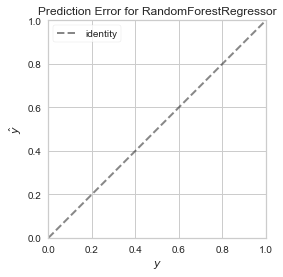

Wall time: 11min 21s


In [123]:
%%time
RFPred1 = RandomForest('Random Forest', Posdf1719, Year16, '2016 Prediction', 0, 0, 8, 12, 0.3, 'NO')

['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']
Best CV score = 0.303:
Best parameters:  {'reduce_dim': FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=8,
               noise_variance_init=None, random_state=0, svd_method='lapack',
               tol=0.01), 'reduce_dim__n_components': 8}


C:\Users\User\Anaconda3\lib\site-packages\yellowbrick\base.py:237: YellowbrickWarning: PredictionError does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warn_message.format(self.__class__.__name__), YellowbrickWarning


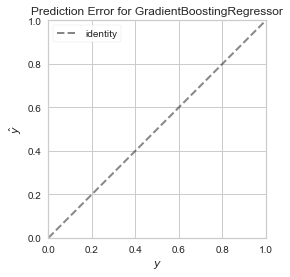

Wall time: 4min 23s


In [124]:
%%time
GBPred1 = GradientBoosting('Gradient Boosting', Posdf1719, Year16, '2016 Prediction', 0, 0, 8, 12, 0.3, 'NO')

['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']


C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best CV score = 0.402:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5,
             random_state=None, tol=0.0), 'reduce_dim__n_components': 8}


C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\yellowbrick\base.py:237: YellowbrickWarning: PredictionError does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warn_message.format(self.__class__.__name__), YellowbrickWarning


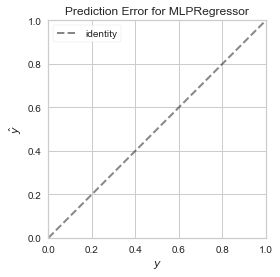

Wall time: 1min 35s


In [125]:
%%time
MLPPred1 = ANN('ANN', Posdf1719, Year16, '2016 Prediction', 0, 0, 8, 0.3, 'NO')

['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']
Best CV score = 0.244:
Best parameters:  {'reduce_dim': FastICA(algorithm='deflation', fun='logcosh', fun_args=None, max_iter=200,
        n_components=9, random_state=None, tol=0.0001, w_init=None,
        whiten=True), 'reduce_dim__n_components': 9, 'regresson__normalize': False}


C:\Users\User\Anaconda3\lib\site-packages\yellowbrick\base.py:237: YellowbrickWarning: PredictionError does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warn_message.format(self.__class__.__name__), YellowbrickWarning


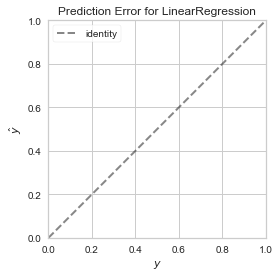

Wall time: 5min 33s


In [126]:
%%time
LRPred1 = LRegress('Linear Regression', Posdf1719, Year16, '2020 Prediction', 0, 0, 9, 0.3, 'NO')

['Hour', 'rain', 'temp', 'msl', 'wdsp', 'wddir', 'Ozone', 'SO2']


C:\Users\User\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best CV score = 0.416:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5,
             random_state=None, tol=0.0), 'reduce_dim__n_components': 8}


C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\yellowbrick\base.py:237: YellowbrickWarning: PredictionError does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warn_message.format(self.__class__.__name__), YellowbrickWarning


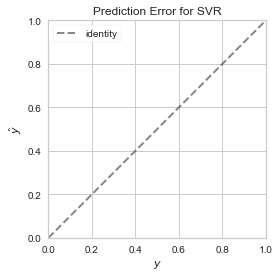

Wall time: 1min 27s


In [127]:
%%time
SVMPred1 = SVM('SVM', Posdf1719, Year16, '2016 Prediction', 0, 0, 8, 0.3, 'NO')

# Check actual daily data types before working on predictions

In [128]:
NO2_Day.dtypes

Date    datetime64[ns]
NO2            float64
dtype: object

In [129]:
NO2_Day['Date'] = NO2_Day['Date'].astype('datetime64')
NO2_Day['NO2'] = NO2_Day['NO2'].astype('float')

In [130]:
display(NO2_Day)

,Date,NO2
0,2016-01-01,16.524153
1,2016-01-02,20.392566
2,2016-01-03,20.304361
3,2016-01-04,55.825056
4,2016-01-05,32.906382
5,2016-01-06,20.797115
6,2016-01-07,15.428556
7,2016-01-08,38.041497
8,2016-01-09,48.367434
9,2016-01-10,13.932389


# Now translate hourly predictions to daily predictions and plot the actual and predictions
Remember how the predictions and actual data are the same number of days so we just need to average the predictions, assign the relevant date to them and then we can plot them.<br>

Scaling can then be applied

In [141]:
from matplotlib.pyplot import figure

def PredictionPlot(Name, Data1, Data2, Data3, Data4, j):
    PredDates = []
    PredDates = DYear16['Dates'].values
    Preddf = pd.DataFrame(list(zip(PredDates, Data1)), columns=['Date', 'NO2_Predicted_Values'])
    
    ind_date = []
    ind_date = Preddf['Date'].unique()
    
    #Compute prediction daily averages for each unique date
    avg = Preddf.groupby(Preddf.Date).mean()
    
    
    favg = [] #Array for original predicted daily
    favg = avg['NO2_Predicted_Values'].values
    
    #Scaling
    navg = np.zeros(len(favg))
    for i in range(len(favg)):
        navg[i] = favg[i] * j 
        
    a = []
    a = Data3['Dates'].values
    
    rmDdf = Data4[~Data4['Date'].isin(a)]
    
    b = []
    b = rmDdf['Date'].values
    
    
    
    d = []
    d = rmDdf['NO2'].values
    
    Finaldf = pd.DataFrame(list(zip(ind_date, d, navg)), columns=['Date', 'Actual Daily NO2', 'Predicted Daily NO2'])
    Finaldf.dropna(inplace=True)
    
    
    #Plot daily predictions and actual
    Finaldf.plot(x='Date', y=["Actual Daily NO2", "Predicted Daily NO2"], linewidth=0.7, figsize=(25, 10), color=['red', 'blue'])
    plt.title("Graph of Predicted and Actual NO2 daily values for {}".format(Name), fontsize=30)
    plt.xlabel("Date", fontsize=30)
    plt.ylabel("Value ($\mu g / m^{3}$)", fontsize=30)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize = 20)
    plt.legend(fontsize=20)
    plt.show()
    
    Finaldf.plot.scatter(x = 'Actual Daily NO2', y = 'Predicted Daily NO2', linewidth=0.7, figsize=(25, 10))
    plt.title("Graph of Predicted and Actual NO2 daily values for {}".format(Name), fontsize=30)
    plt.xlabel("Actual", fontsize=30)
    plt.ylabel("Predicted", fontsize=30)
    plt.xlim(0, 45)
    plt.ylim(0,60)
    plt.legend(fontsize=20)
    plt.show()
    
    Edf = Finaldf[['Actual Daily NO2', 'Predicted Daily NO2']]
    Edf.to_csv('Day2016 NO2 Excel.csv', index=False)

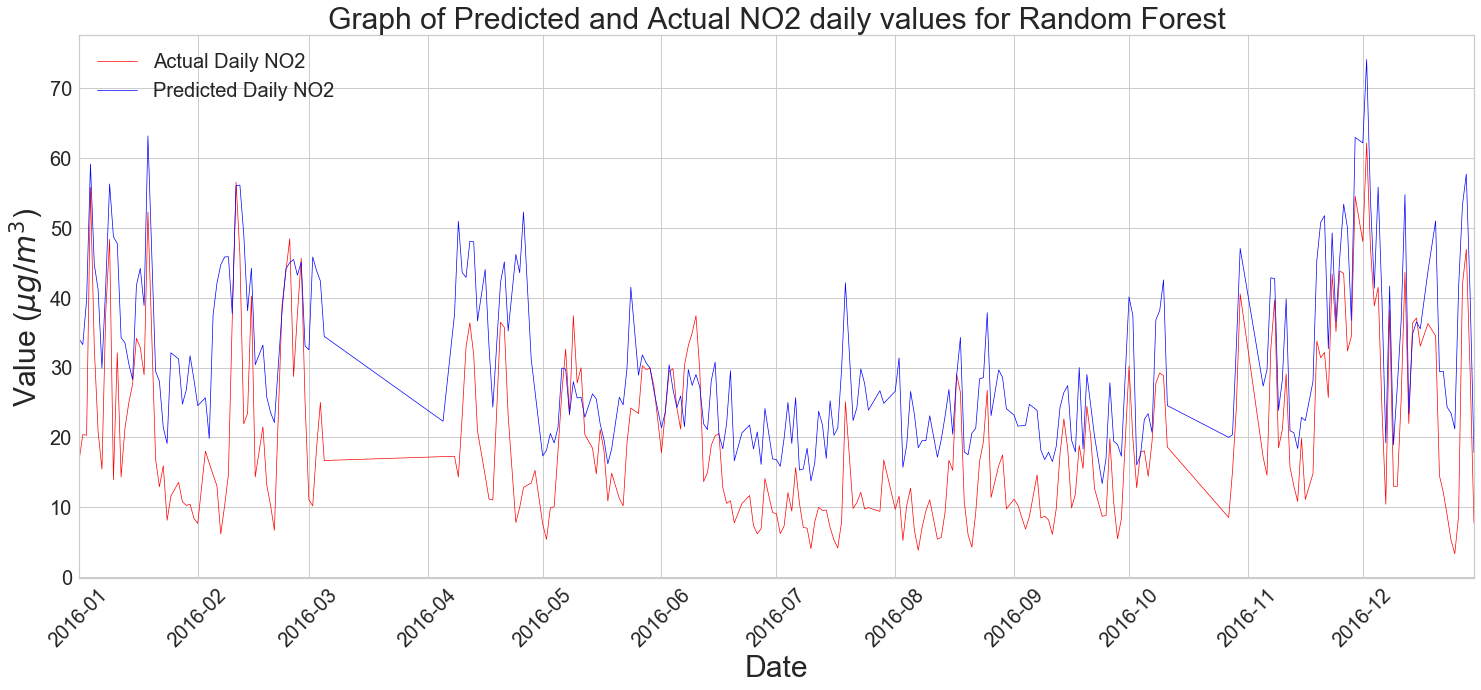

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


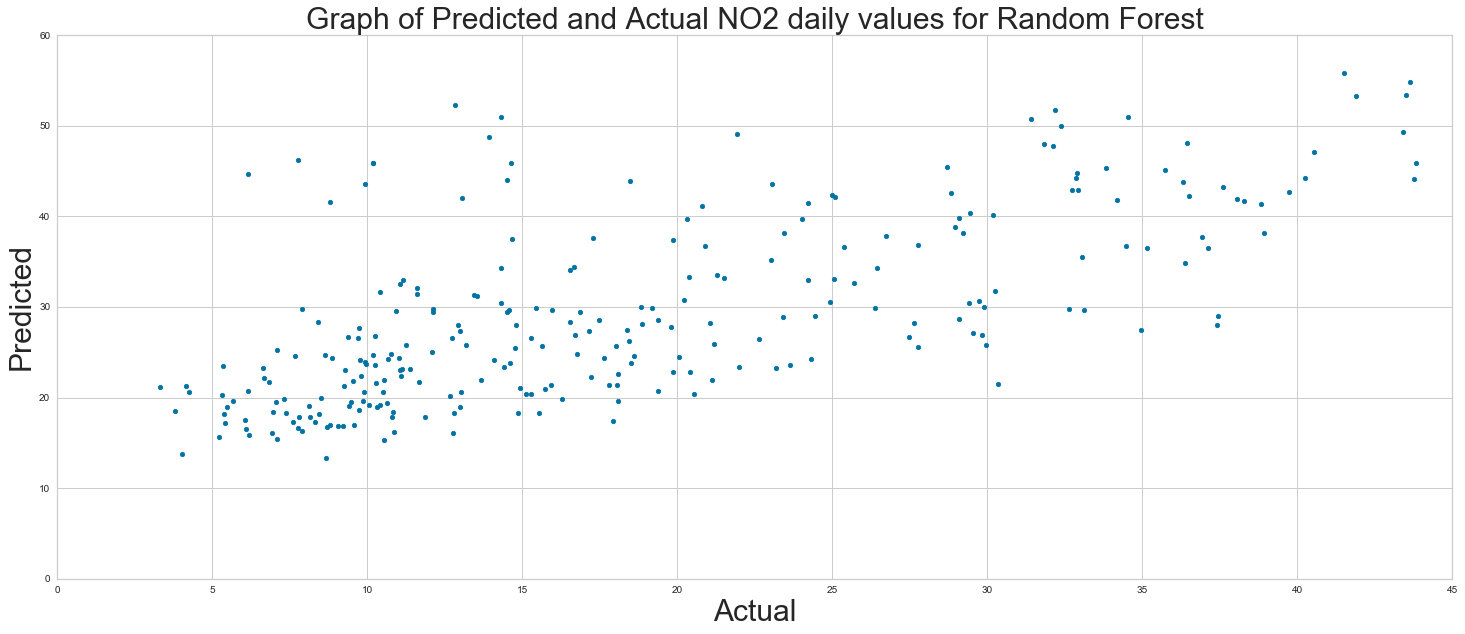

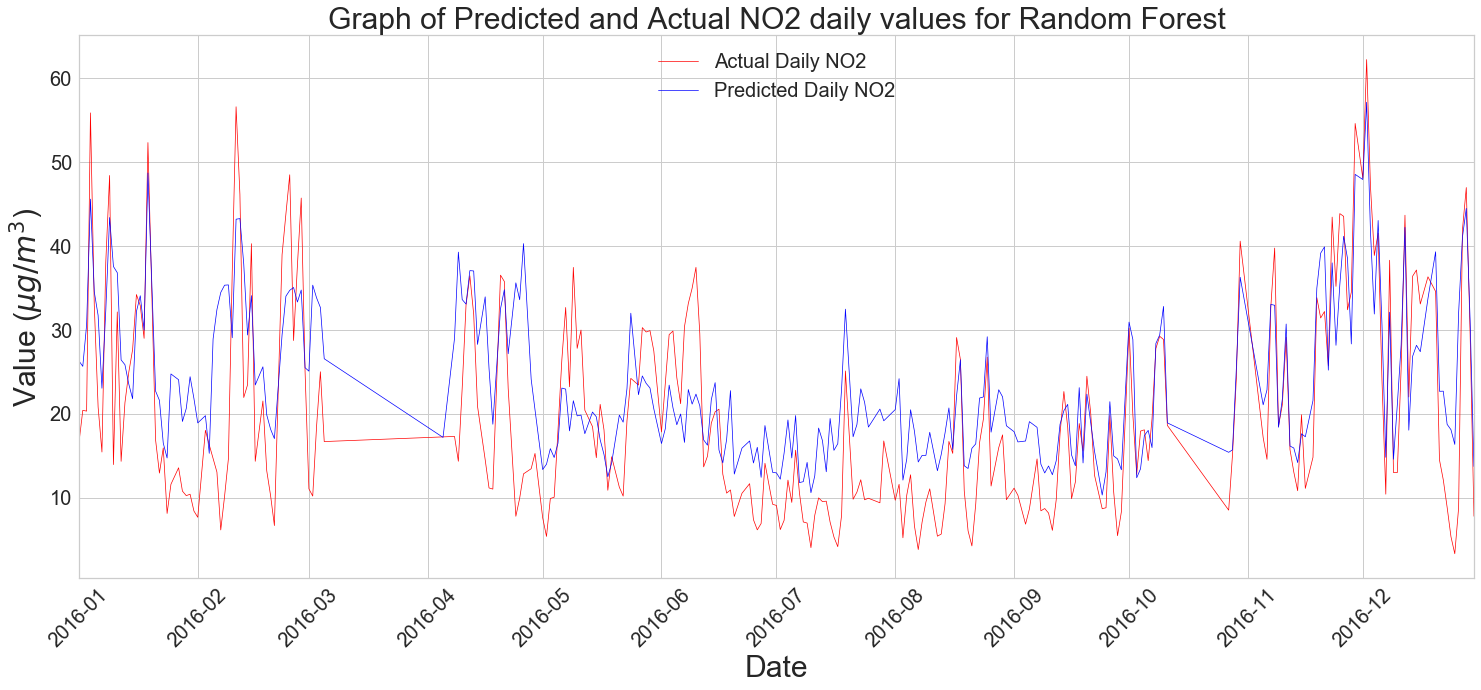

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


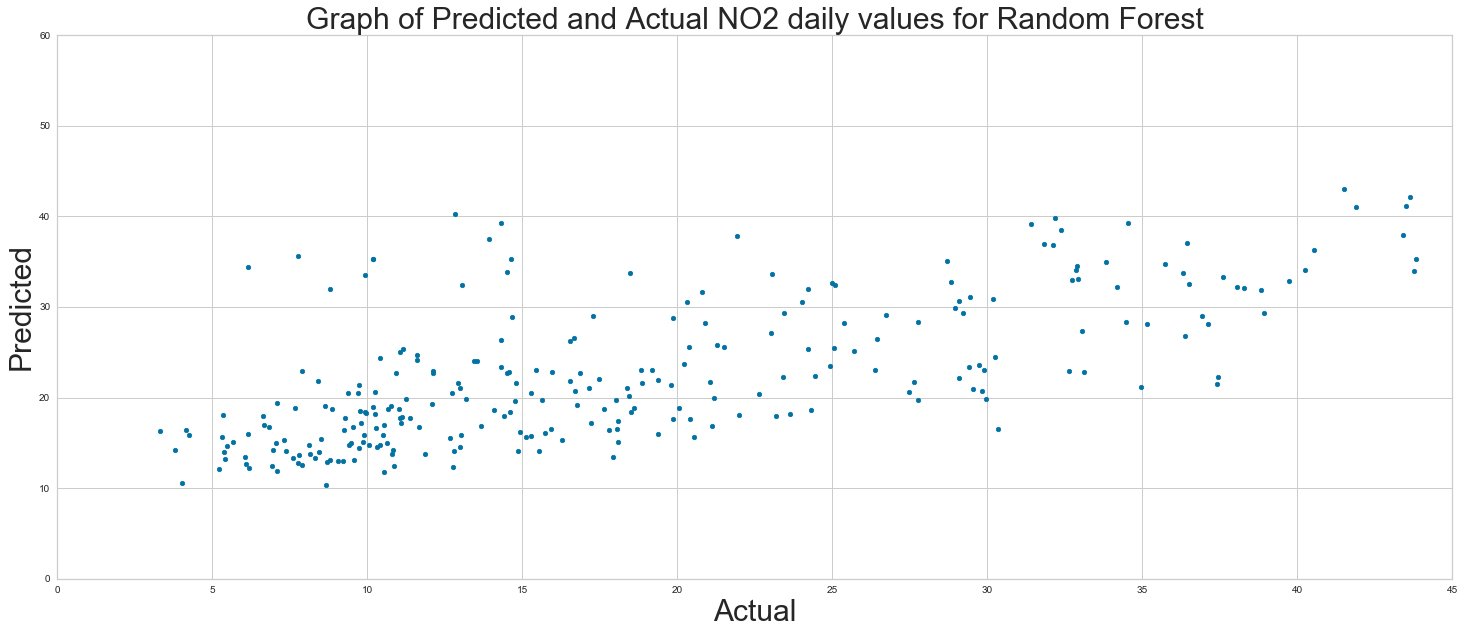

In [142]:
PredictionPlot('Random Forest', RFPred1, df, df16, NO2_Day, 1)
PredictionPlot('Random Forest', RFPred1, df, df16, NO2_Day, .77)

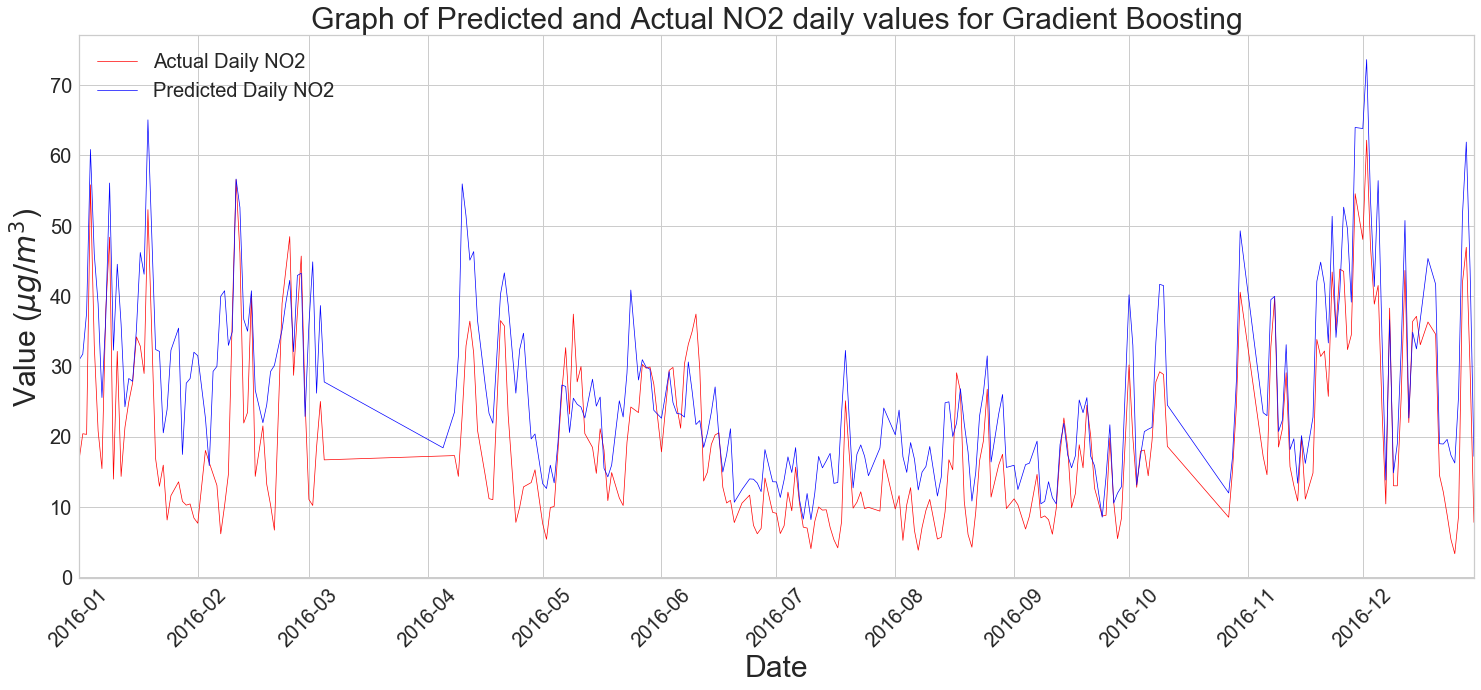

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


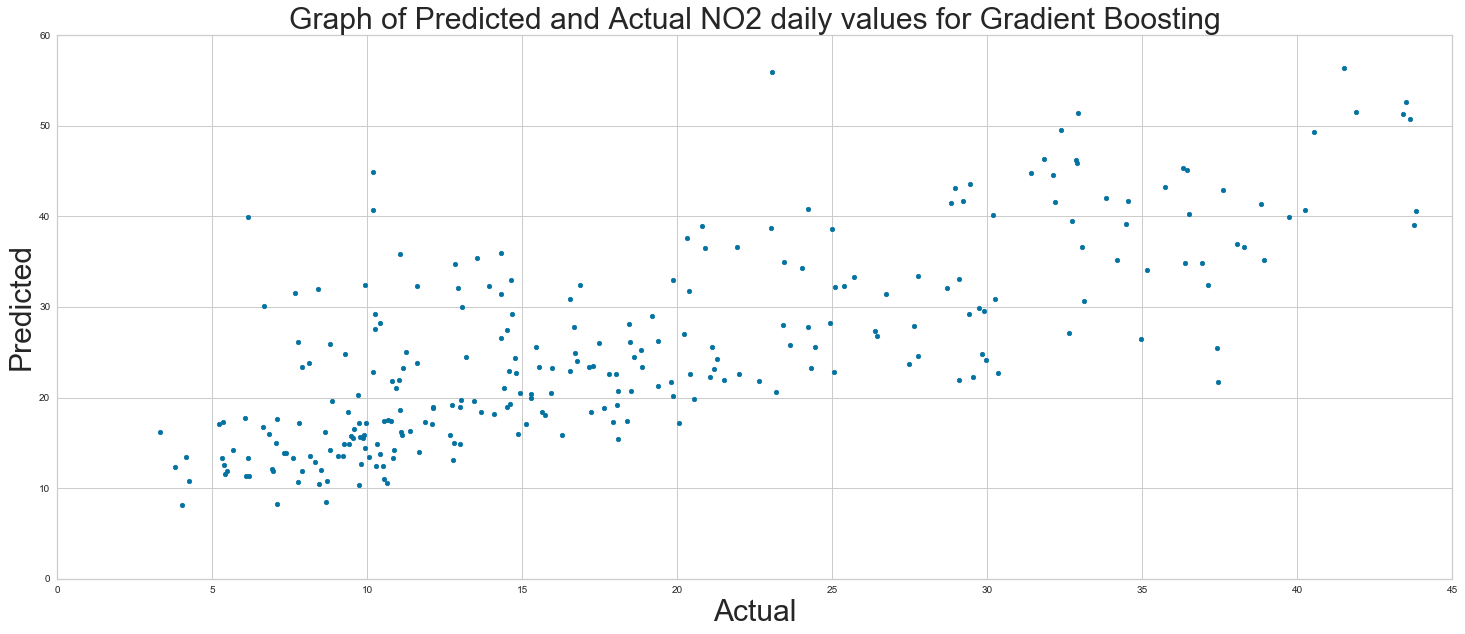

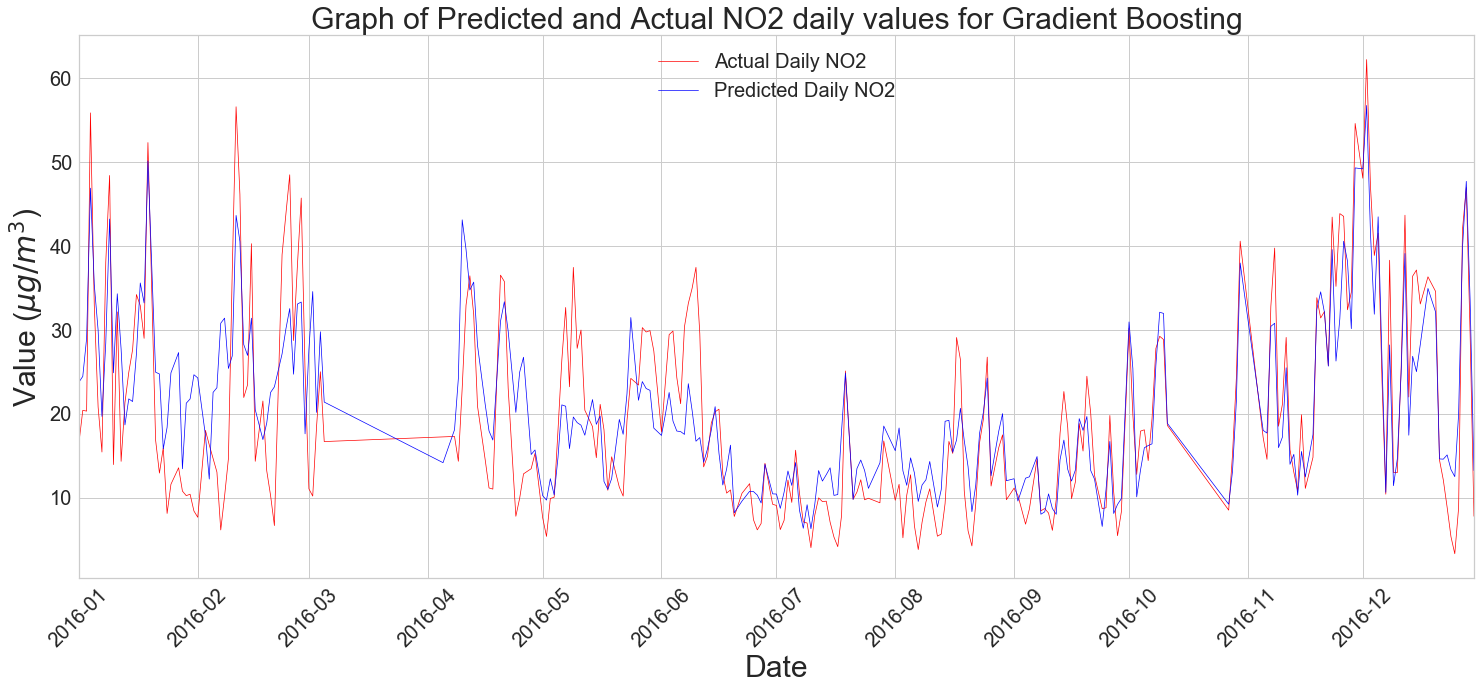

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


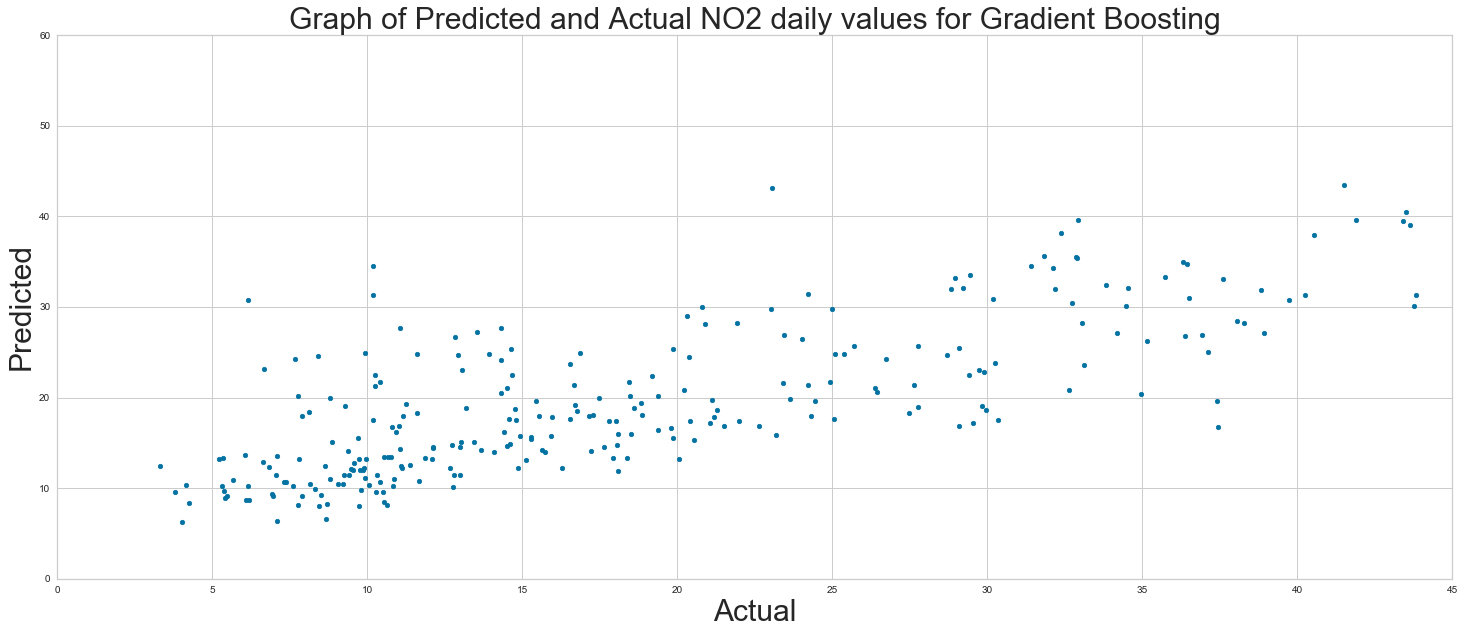

In [143]:
PredictionPlot('Gradient Boosting', GBPred1, df, df16, NO2_Day, 1)
PredictionPlot('Gradient Boosting', GBPred1, df, df16, NO2_Day, .77)

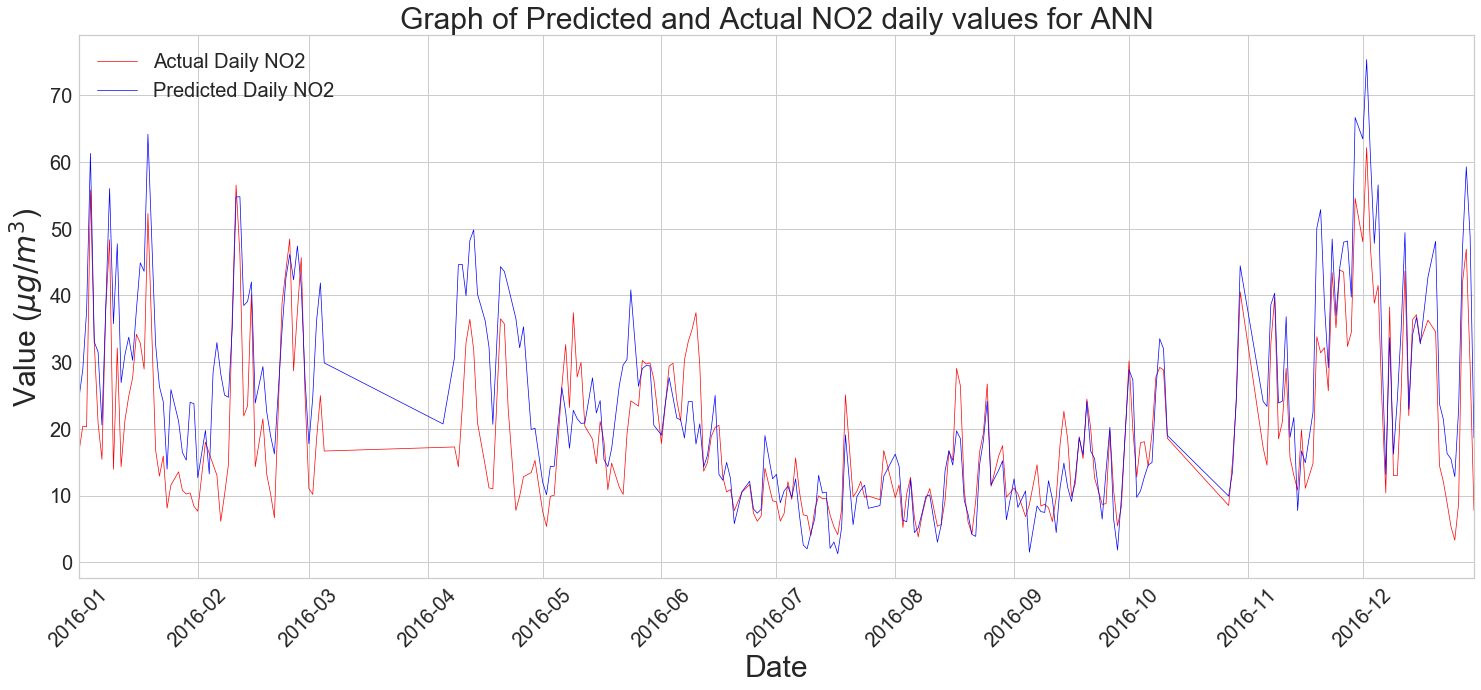

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


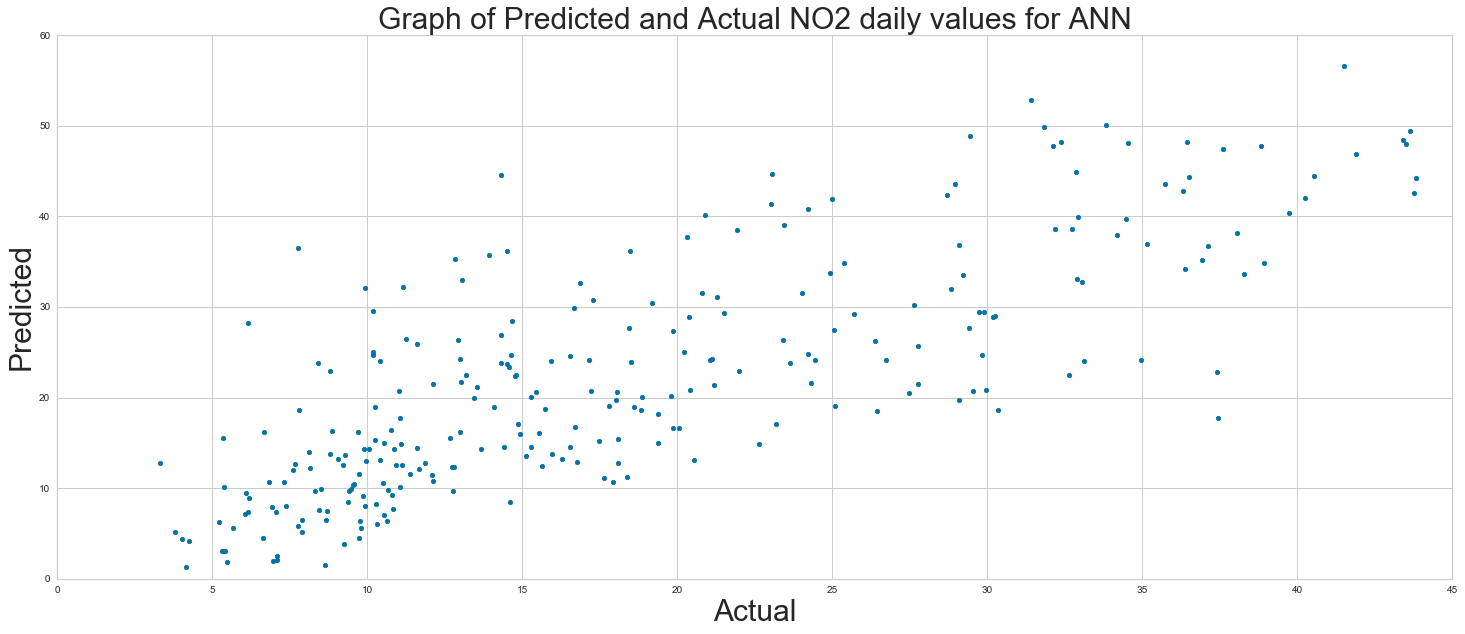

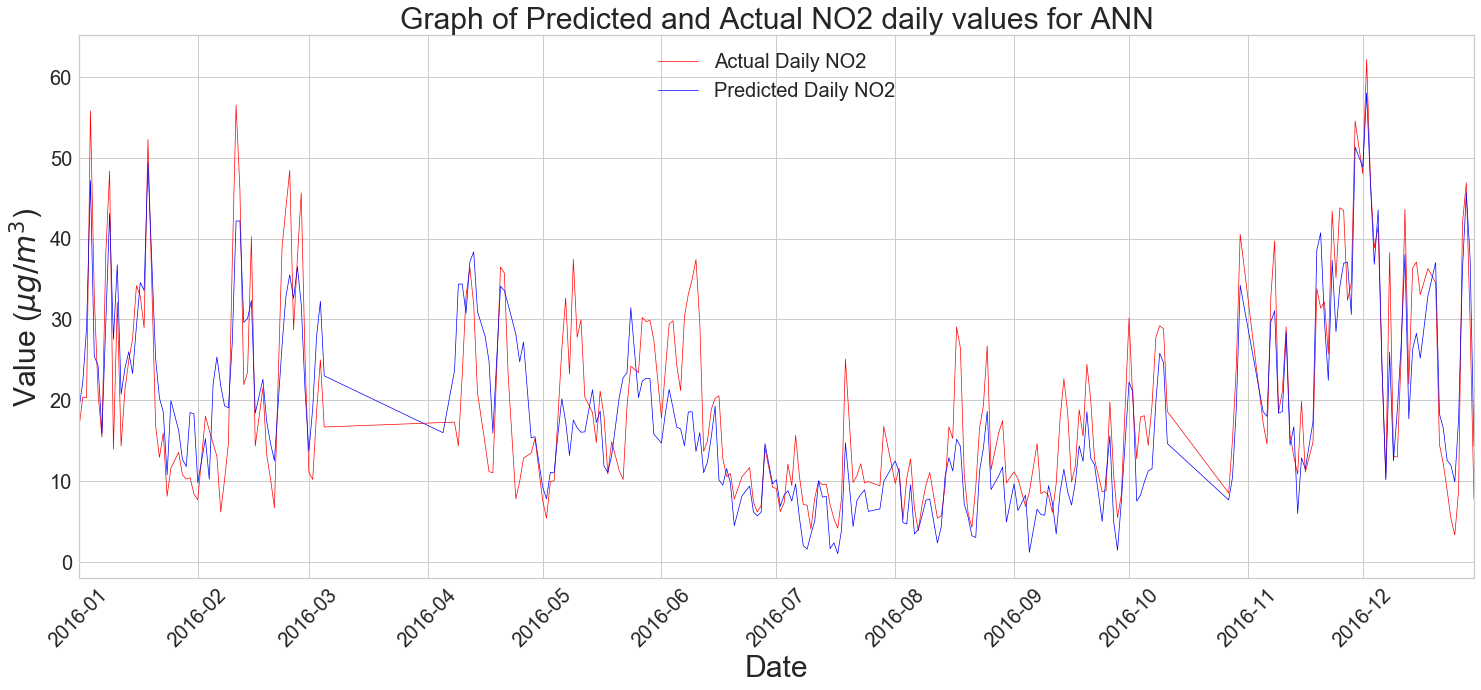

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


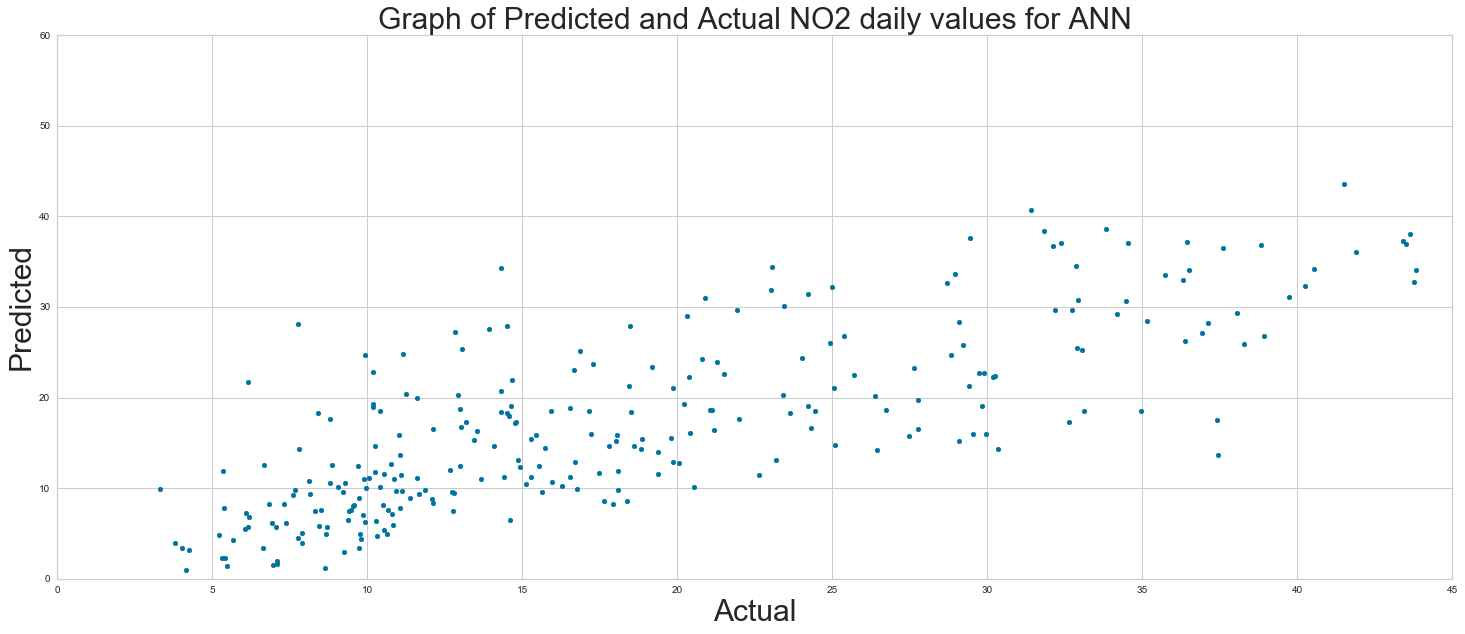

In [145]:
PredictionPlot('ANN', MLPPred1, df, df16, NO2_Day, 1)
PredictionPlot('ANN', MLPPred1, df, df16, NO2_Day, .77)

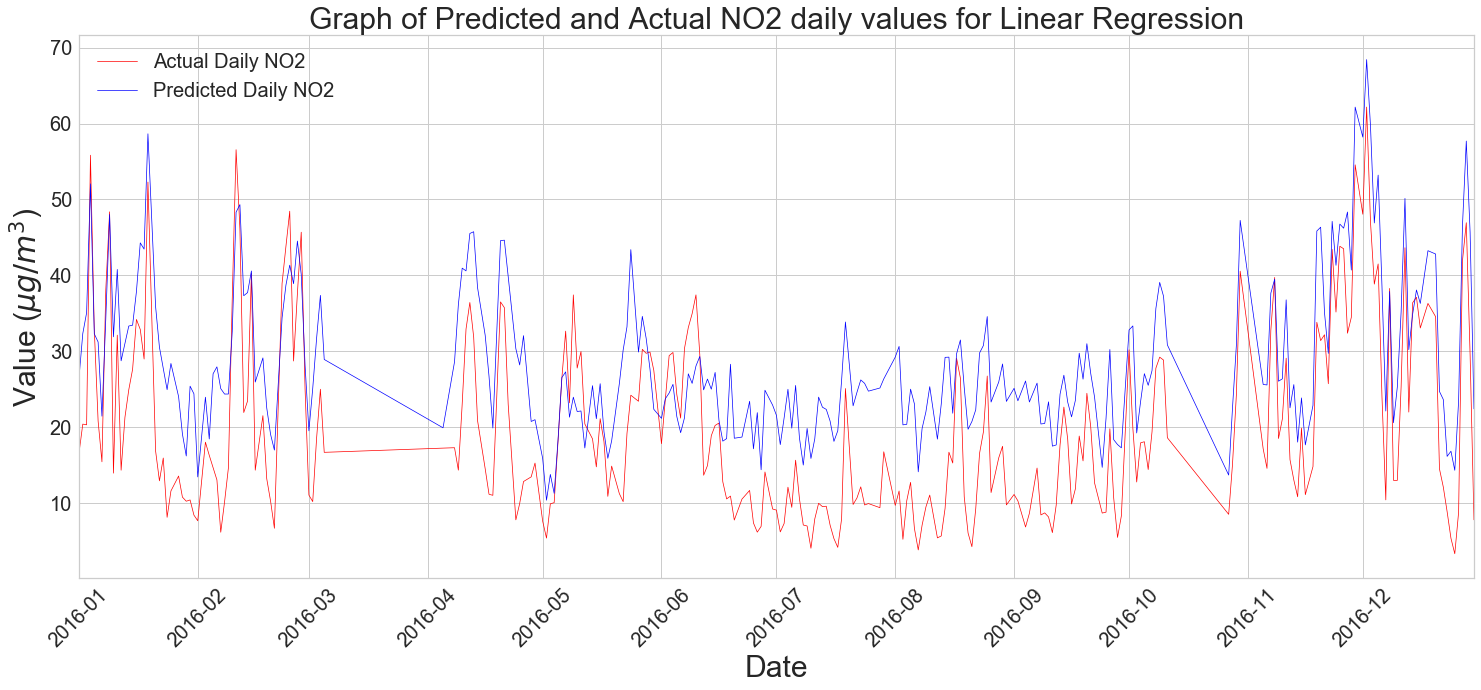

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


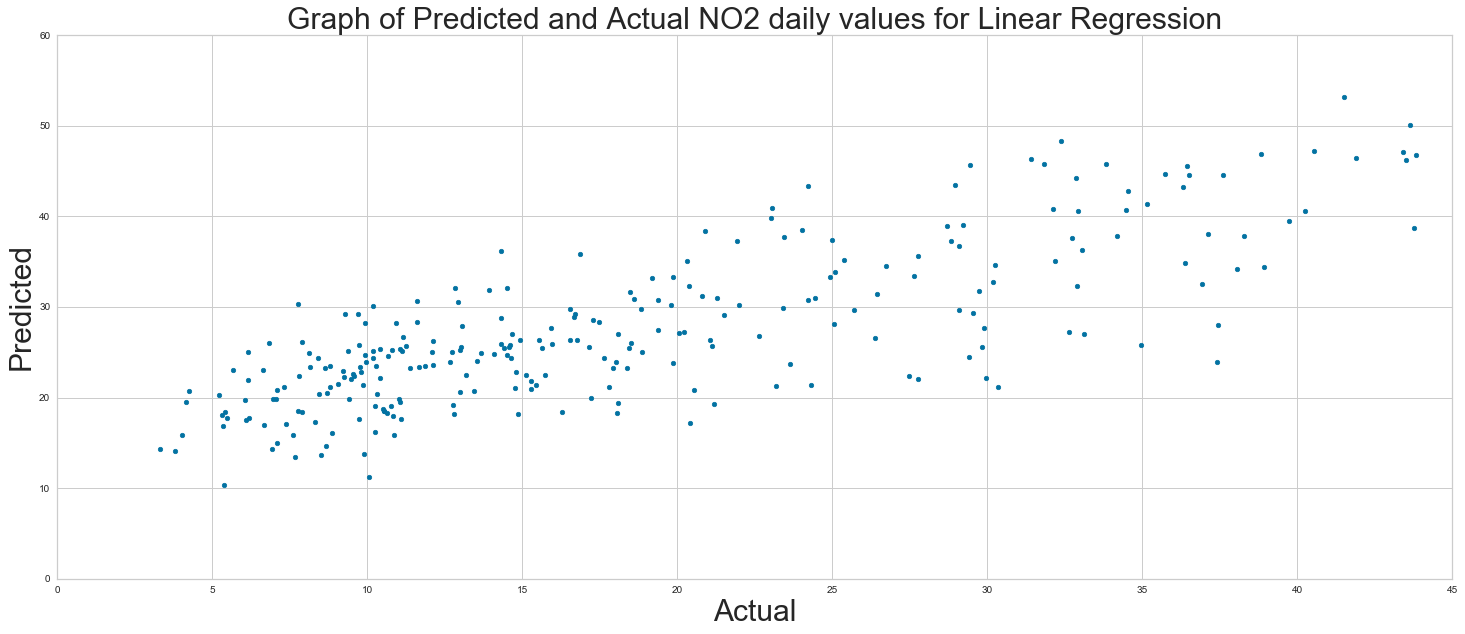

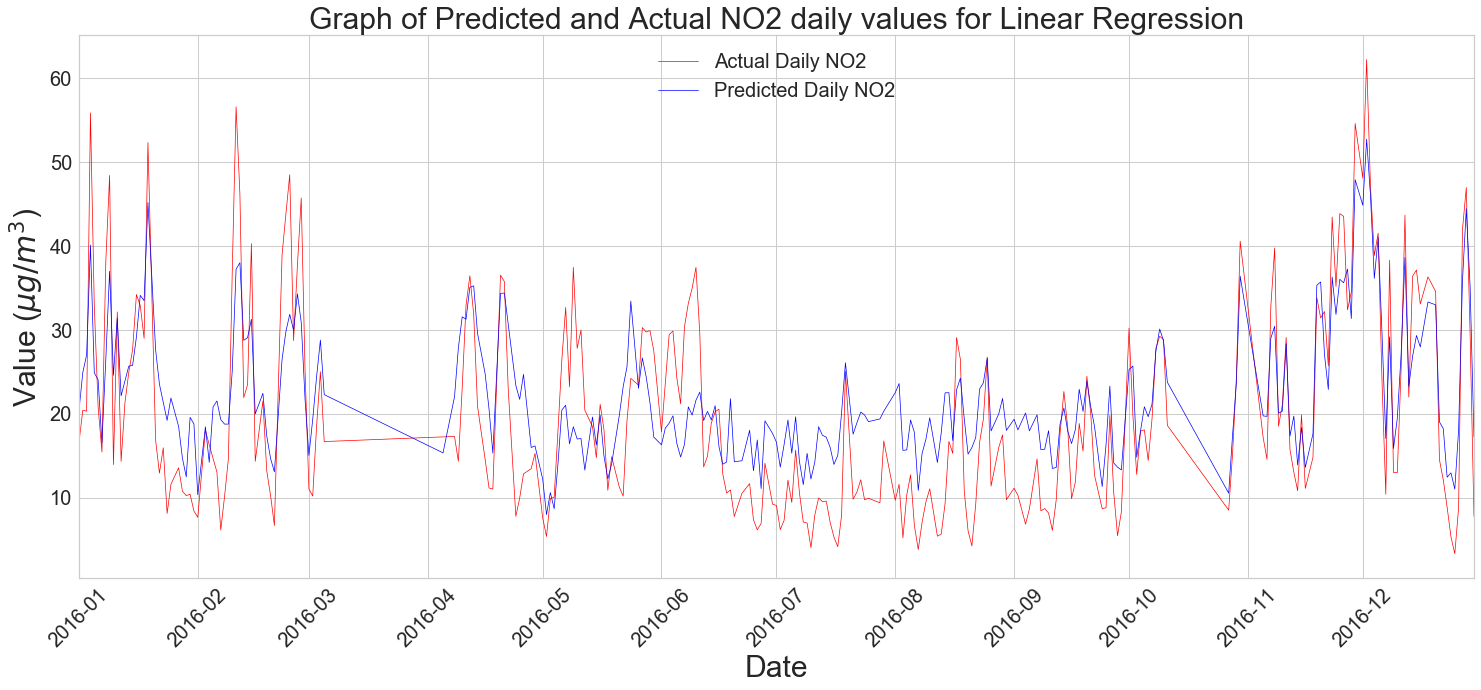

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


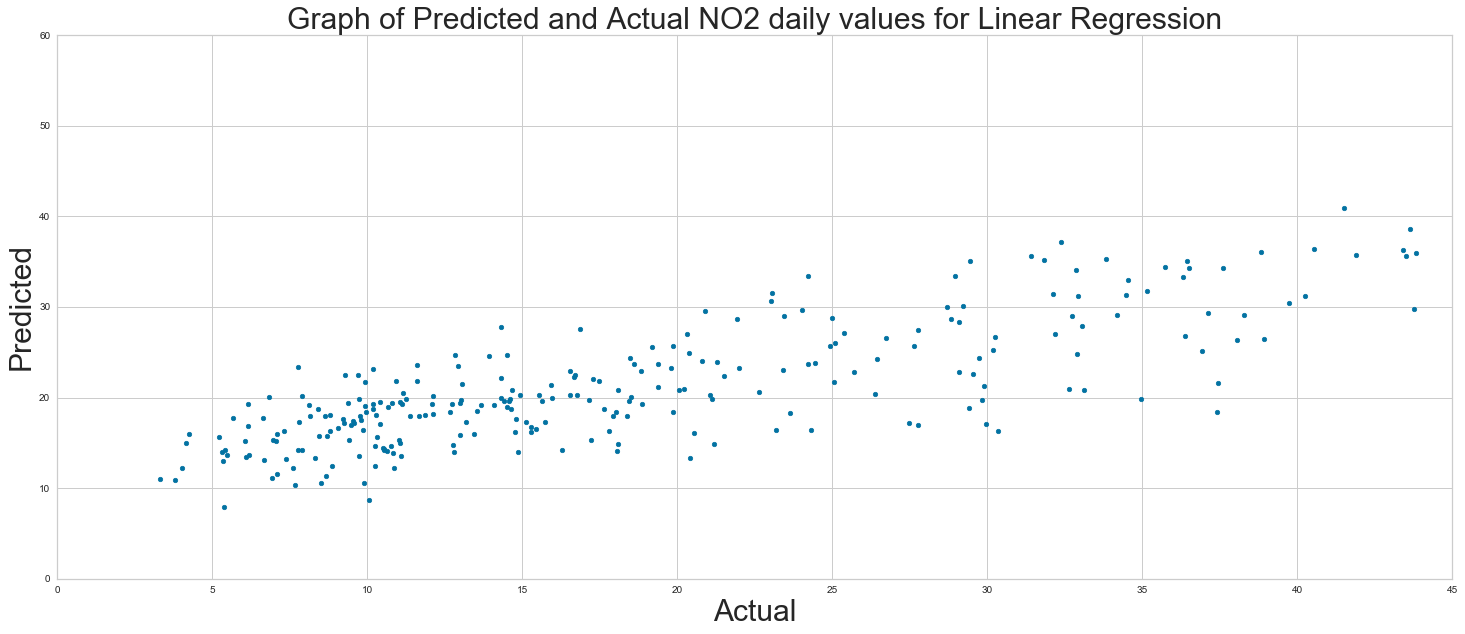

In [147]:
PredictionPlot('Linear Regression', LRPred1, df, df16, NO2_Day, 1)
PredictionPlot('Linear Regression', LRPred1, df, df16, NO2_Day, .77)

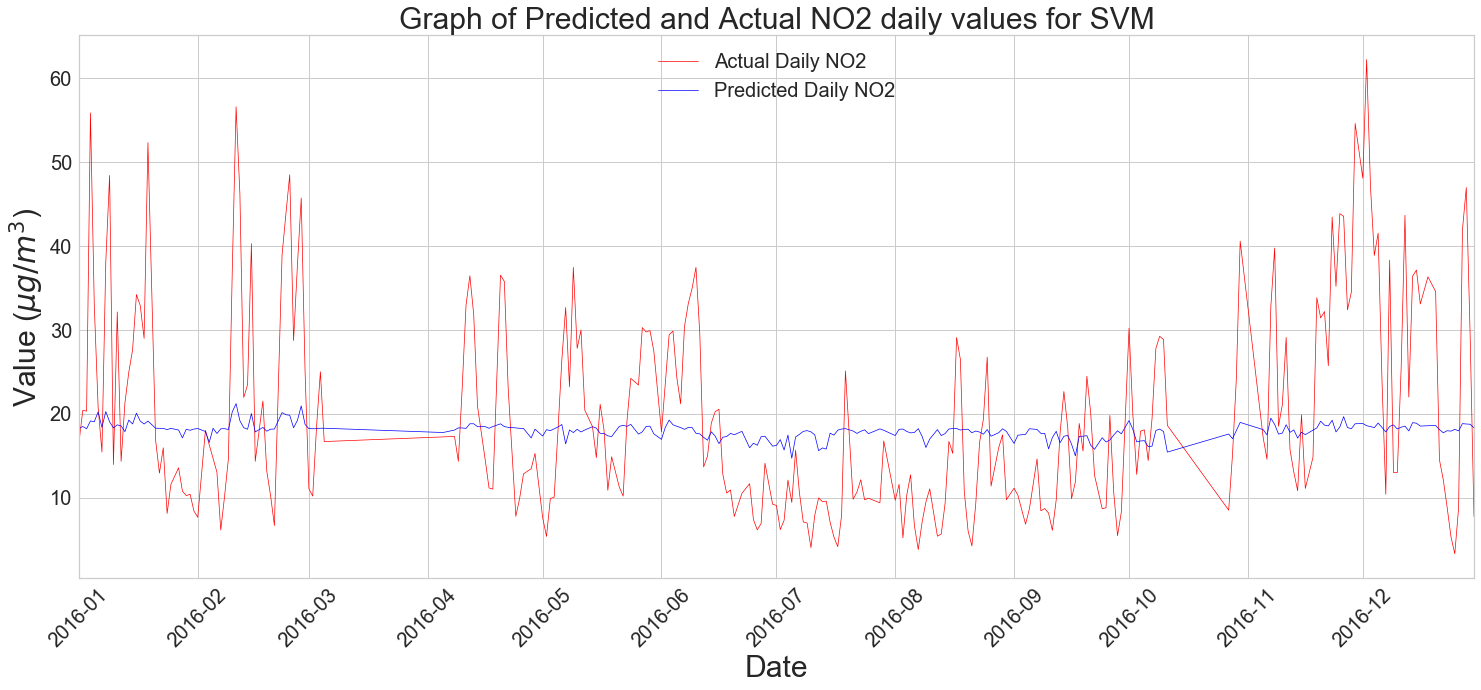

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


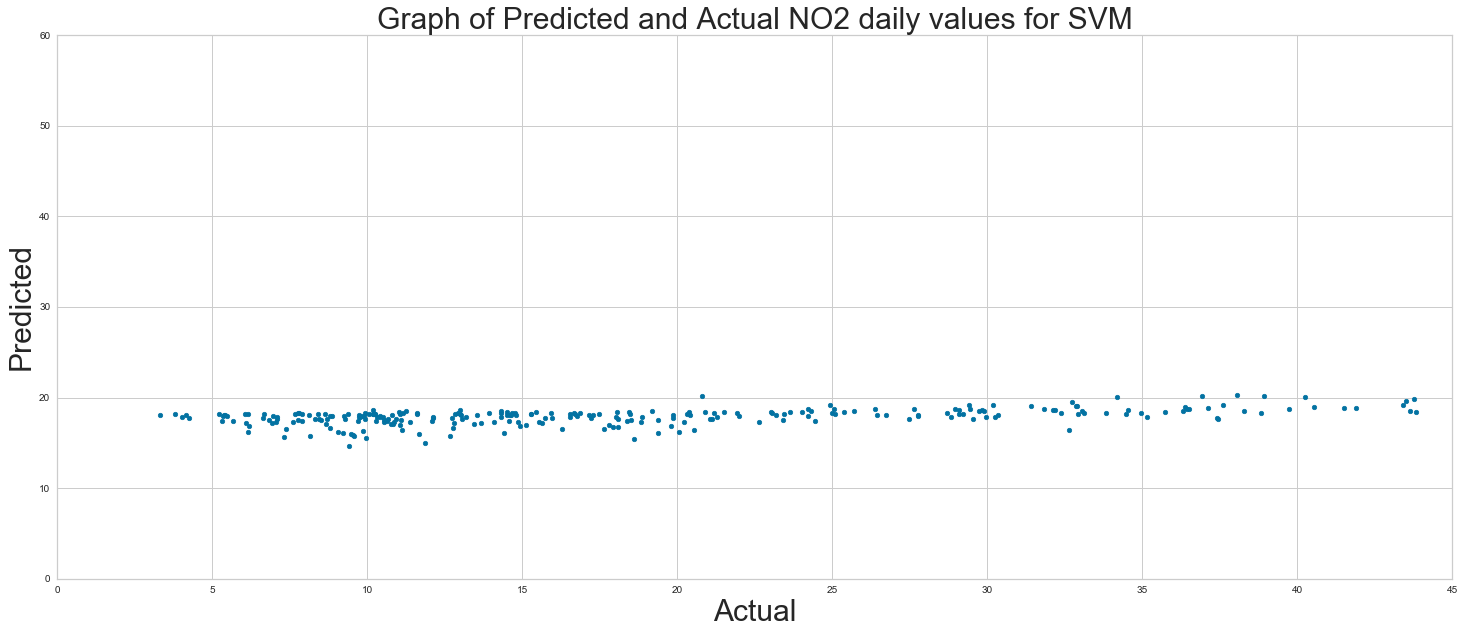

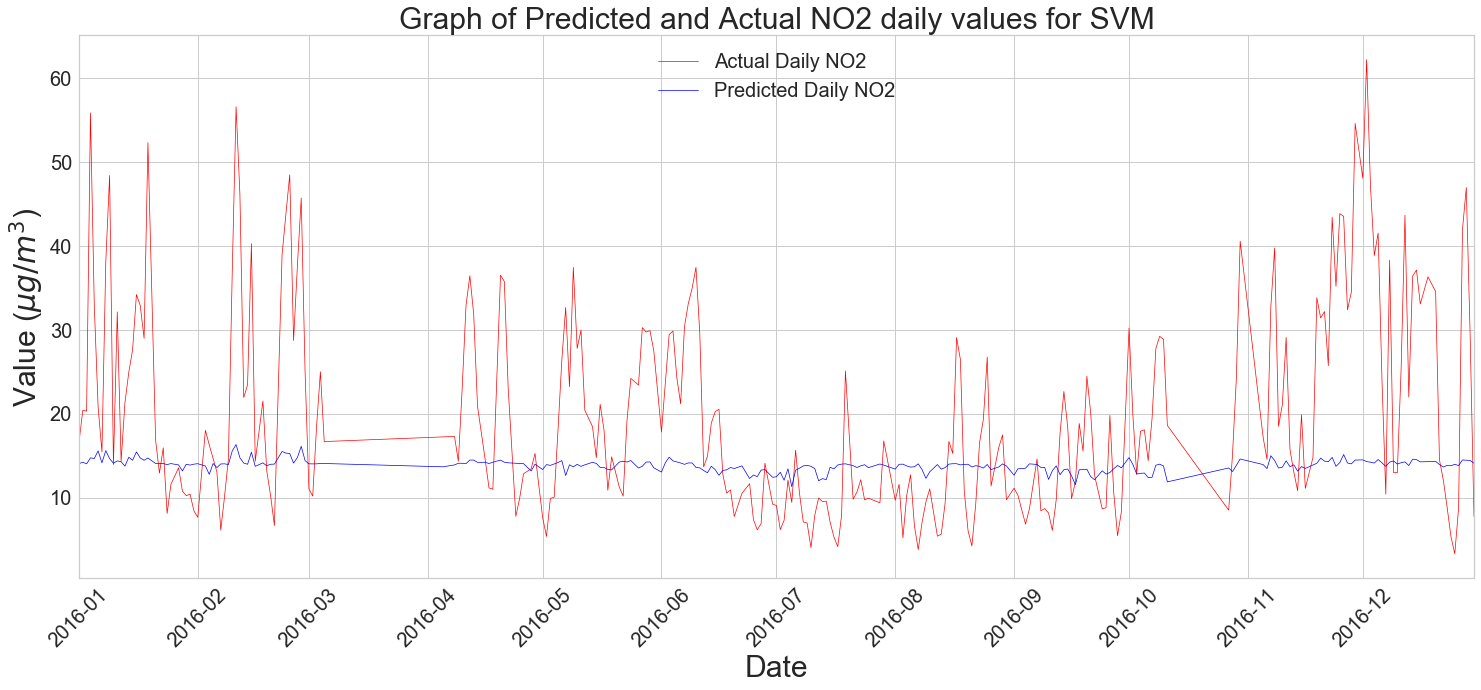

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


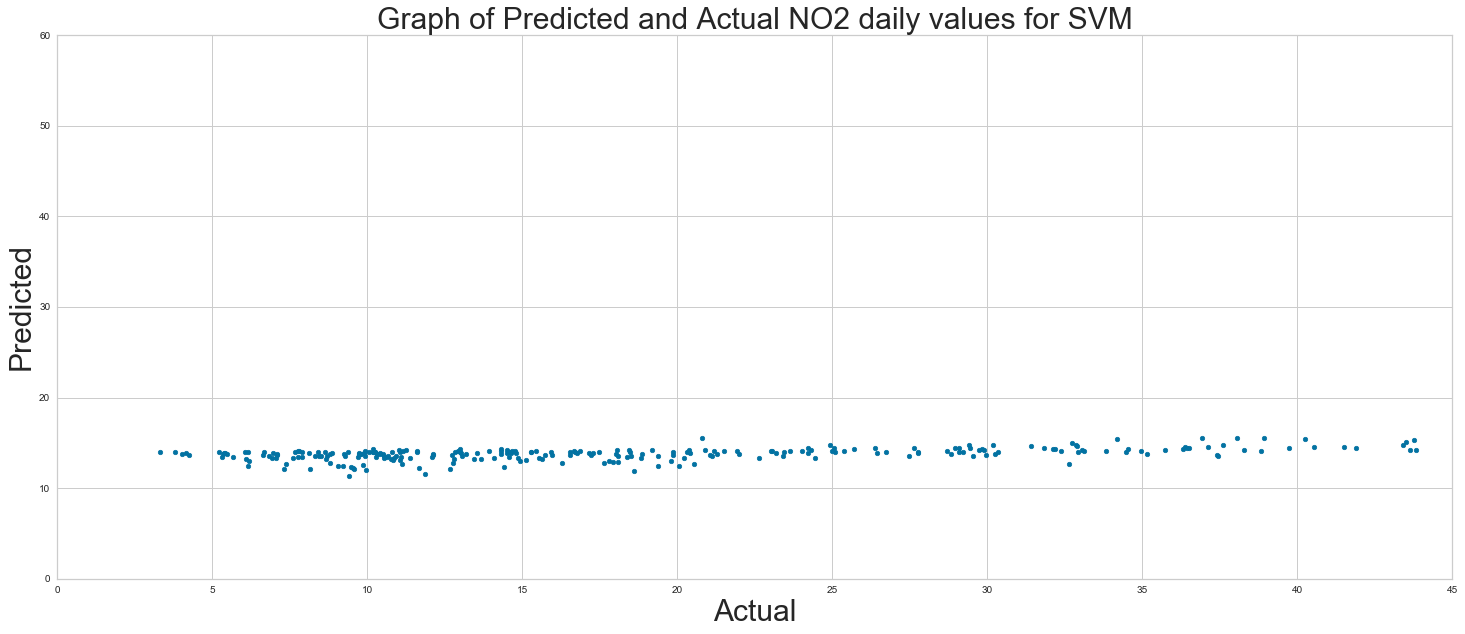

In [148]:
PredictionPlot('SVM', SVMPred1, df, df16, NO2_Day, 1)
PredictionPlot('SVM', SVMPred1, df, df16, NO2_Day, .77)

Please note that only the Random Forest Graphs were included in the dissertation to be concise. However, this illustrated the great potential of daily averaging using these algorithms